## Loading in and checking the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import os

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


Using plaidml.keras.backend backend.


In [3]:
train_data = np.load('./datasets/aug_data_obj.npy')
train_label = np.load('./datasets/aug_labels_obj.npy')
test_data = pd.read_csv('./datasets/test.csv')
train_data = pd.DataFrame(train_data)
train_label = pd.DataFrame(train_label)

## Splitting the data and its label

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11044b940>]],
      dtype=object)

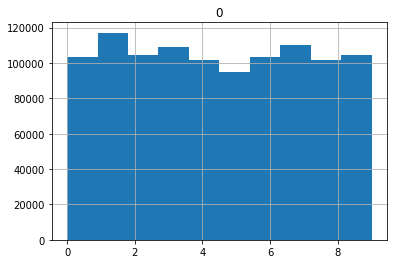

In [3]:
train_label.hist()

In [4]:
train_data[train_data<0] = 0
train_data = train_data / 255.0
test_data = test_data / 255.0

In [5]:
train_data = train_data.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)

In [6]:
train_label = to_categorical(train_label, num_classes=10)

In [7]:
s_train_data, s_val_data, s_train_label, s_val_label = train_test_split(train_data, train_label, test_size=0.002, stratify=train_label)
train_data=None

## Checking the image quality of a random value

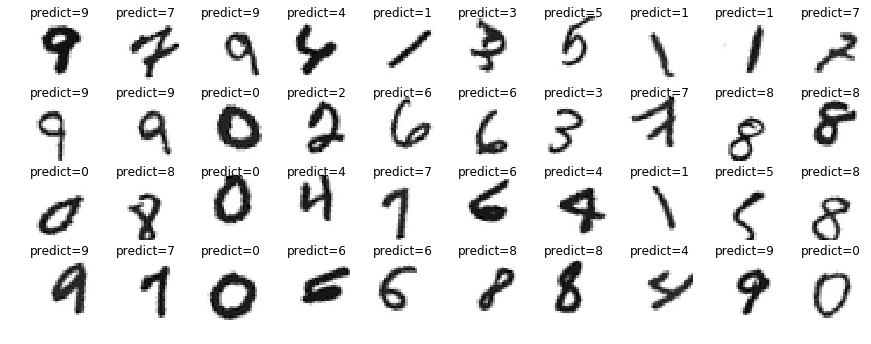

In [8]:
from matplotlib import cm

plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(s_train_data[i][:,:,0], cmap=cm.binary)
    plt.title("predict=%d" % np.argmax(s_train_label[i]),y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()


# Attempting to solve using a CNN

In [9]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

INFO:plaidml:Opening device "metal_amd_radeon_vega_frontier_edition.0"


In [10]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 100
batch_size = 7680 # Warning size choosen based on a GPU with 16GB of memory and utalizes ~95%.

In [11]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [12]:
datagen.fit(s_train_data)

## Testing results with given data

In [13]:
import scipy.ndimage
history = model.fit_generator(datagen.flow(s_train_data,s_train_label, batch_size=batch_size),
                              epochs = epochs, validation_data = (s_val_data,s_val_label),
                              verbose = 2, steps_per_epoch=s_train_data.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


Epoch 1/100


INFO:plaidml:Analyzing Ops: 109 of 303 operations complete
INFO:plaidml:Analyzing Ops: 115 of 303 operations complete


 - 491s - loss: 1.1123 - acc: 0.6489 - val_loss: 0.1911 - val_acc: 0.9419
Epoch 2/100
 - 489s - loss: 0.3003 - acc: 0.9091 - val_loss: 0.0653 - val_acc: 0.9781
Epoch 3/100
 - 490s - loss: 0.1611 - acc: 0.9519 - val_loss: 0.0358 - val_acc: 0.9862
Epoch 4/100
 - 489s - loss: 0.1100 - acc: 0.9674 - val_loss: 0.0251 - val_acc: 0.9924
Epoch 5/100
 - 490s - loss: 0.0843 - acc: 0.9749 - val_loss: 0.0252 - val_acc: 0.9924
Epoch 6/100
 - 492s - loss: 0.0695 - acc: 0.9792 - val_loss: 0.0180 - val_acc: 0.9943
Epoch 7/100
 - 490s - loss: 0.0593 - acc: 0.9822 - val_loss: 0.0188 - val_acc: 0.9924
Epoch 8/100
 - 490s - loss: 0.0533 - acc: 0.9842 - val_loss: 0.0187 - val_acc: 0.9948
Epoch 9/100
 - 489s - loss: 0.0471 - acc: 0.9859 - val_loss: 0.0146 - val_acc: 0.9952
Epoch 10/100
 - 490s - loss: 0.0430 - acc: 0.9871 - val_loss: 0.0117 - val_acc: 0.9962
Epoch 11/100
 - 489s - loss: 0.0396 - acc: 0.9881 - val_loss: 0.0098 - val_acc: 0.9971
Epoch 12/100
 - 492s - loss: 0.0369 - acc: 0.9889 - val_loss: 0.

 - 477s - loss: 0.0166 - acc: 0.9950 - val_loss: 0.0053 - val_acc: 0.9986
Epoch 90/100
 - 482s - loss: 0.0166 - acc: 0.9950 - val_loss: 0.0051 - val_acc: 0.9986
Epoch 91/100
 - 487s - loss: 0.0161 - acc: 0.9952 - val_loss: 0.0052 - val_acc: 0.9986
Epoch 92/100
 - 485s - loss: 0.0162 - acc: 0.9950 - val_loss: 0.0052 - val_acc: 0.9986
Epoch 93/100
 - 482s - loss: 0.0163 - acc: 0.9951 - val_loss: 0.0052 - val_acc: 0.9986
Epoch 94/100
 - 480s - loss: 0.0160 - acc: 0.9951 - val_loss: 0.0052 - val_acc: 0.9986
Epoch 95/100
 - 479s - loss: 0.0163 - acc: 0.9950 - val_loss: 0.0053 - val_acc: 0.9986
Epoch 96/100
 - 479s - loss: 0.0164 - acc: 0.9950 - val_loss: 0.0051 - val_acc: 0.9986
Epoch 97/100
 - 478s - loss: 0.0164 - acc: 0.9951 - val_loss: 0.0053 - val_acc: 0.9986
Epoch 98/100
 - 485s - loss: 0.0161 - acc: 0.9951 - val_loss: 0.0051 - val_acc: 0.9986
Epoch 99/100
 - 485s - loss: 0.0162 - acc: 0.9950 - val_loss: 0.0052 - val_acc: 0.9986
Epoch 100/100
 - 486s - loss: 0.0164 - acc: 0.9950 - val

## Building our results

In [14]:
results = model.predict(test_data)

In [15]:
results = np.argmax(results,axis = 1)

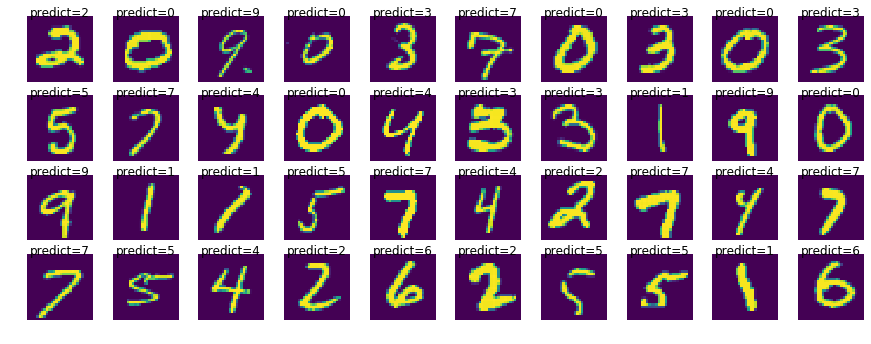

In [16]:
# Preview predictions
plt.figure(figsize=(15,6))
for i in range(40):  
    plt.subplot(4, 10, i+1)
    plt.imshow(test_data[i][:,:,0])
    plt.title("predict=%d" % results[i],y=0.9)
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.show()

In [17]:
# Exporting our results for Kaggle
df = pd.DataFrame(results)
df.index.name='ImageId'
df.index+=1
df.columns=['Label']
df.to_csv('./datasets/results-cnn-lds.csv', header=True)

scored 99.585% on Kaggle